In [ ]:
# !pip install mplcyberpunk

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use("cyberpunk")

# Parameters 

### Recordings

In [11]:
years = range(2025, 2032)
recording_days_per_year = [100, 200, 200, 200, 200, 200, 200]
n_setups = [3, 10, 20, 20, 20, 20, 20]
n_npx_per_setup = [2, 5, 10, 10, 10, 10, 10]

n_channels = 1536 # recording channels npx3.0
sampling_rate = 32e3 # Hz
bytes_per_channel = 2
duration = 3600*3 # seconds

n_neurons_per_electrode = n_channels // 2
n_multi_units = n_channels // 3
firing_rate_per_neuron = 10 # Hz
bytes_per_spike = 4 # uint32

n_lfps_per_npx = n_channels // 20 # record LFPs at every 20th channel
n_LFP_bands = 10 # delta -> High Gamma
lfp_freq = 30 # Hz
bytes_per_lfp = 4 # float32

### data

In [12]:
raw_bytes, n_spikes, raw_spikes, n_mua, raw_mua, n_lfp, raw_lfp = [], [], [], [], [], [], []

for i, y in enumerate(years):
    ## raw data
    x = duration * bytes_per_channel * sampling_rate * n_channels * n_npx_per_setup[i] * n_setups[i] * recording_days_per_year[i]
    raw_bytes.append(x)

    # spikes
    x = duration * firing_rate_per_neuron * n_neurons_per_electrode * n_npx_per_setup[i] * n_setups[i] * recording_days_per_year[i]
    n_spikes.append(x)
    raw_spikes.append(x * bytes_per_spike)

    # MUA
    x = duration * firing_rate_per_neuron * n_multi_units * n_npx_per_setup[i] * n_setups[i] * recording_days_per_year[i]
    n_mua.append(x)
    raw_mua.append(x * bytes_per_spike)

    # LFP
    x = duration * lfp_freq * n_lfps_per_npx * n_LFP_bands * n_npx_per_setup[i] * n_setups[i] * recording_days_per_year[i]
    n_lfp.append(x)
    raw_lfp.append(x * bytes_per_lfp)

# Dataset Size Plot

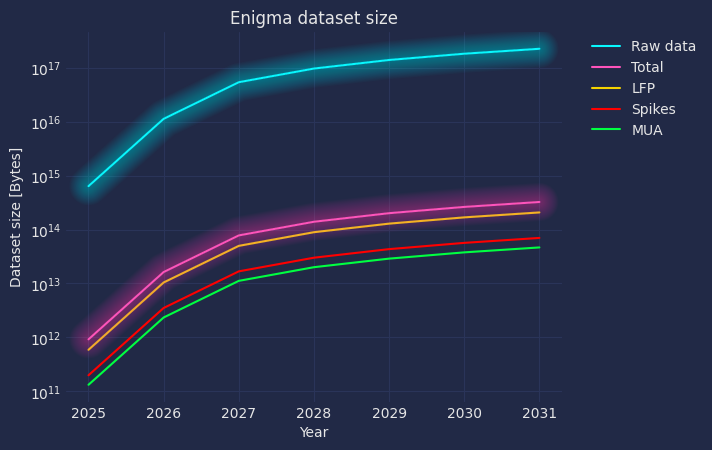

In [25]:
fig, ax = plt.subplots()

total = np.cumsum(raw_lfp) + np.cumsum(raw_mua) + np.cumsum(raw_spikes)
x5 = ax.plot(years, np.cumsum(raw_bytes), label="Raw data", color="C0")


x1 = ax.plot(years, total, label="Total", color="C1")
x4 = ax.plot(years, np.cumsum(raw_lfp), label="LFP", color="C2")
x2 = ax.plot(years, np.cumsum(raw_spikes), label="Spikes", color="C4")
x3 = ax.plot(years, np.cumsum(raw_mua), label="MUA", color="C3")



ax.set(ylabel="Dataset size [Bytes]", xlabel="Year", title="Enigma dataset size")
plt.yscale('log')

plt.legend(loc=(1.05, .7))
mplcyberpunk.make_lines_glow(n_glow_lines=25, alpha_line=.5, lines=[ x1[0], x5[0]])
plt.savefig("Engima_dataset_size.png", dpi=150, bbox_inches="tight")

# Foundation model plot

In [71]:
params =[1e9, 10e9, 100e9]
flops_per_day = 300e12 * 3600 * 24 # H200 GPU Flops/day
flops_per_model = [6 * total_tokens * p for p in params] # FLOP estimte from https://www.factorialfunds.com/blog/thoughts-on-llama-3

gpt3_tokens = 400e9
gpt4_tokens = 15e12
llama4_tokens = 40e12

cost_per_day = 2 * 24
inference_cost = 2

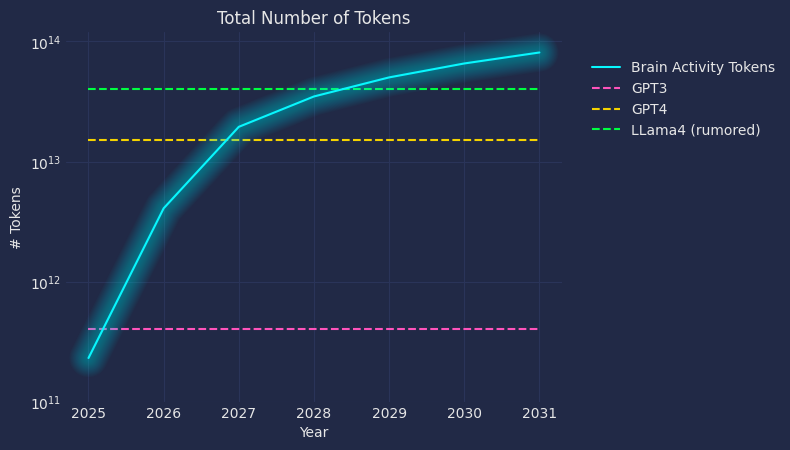

In [72]:
fig, ax = plt.subplots()

total_tokens = np.cumsum(n_mua) + np.cumsum(n_spikes) + np.cumsum(n_lfp)
x1 = ax.plot(years, total_tokens, label="Brain Activity Tokens", color="C0", zorder=1000)

ax.plot([years[0], years[-1]], [gpt3_tokens, gpt3_tokens], '--', label="GPT3", color="C1", )
ax.plot([years[0], years[-1]], [gpt4_tokens, gpt4_tokens], '--', label="GPT4", color="C2", )
ax.plot([years[0], years[-1]], [llama4_tokens, llama4_tokens], '--', label="LLama4 (rumored)", color="C3", )

ax.set(ylabel="# Tokens", xlabel="Year", title="Total number of tokens")
plt.ylim([1e11, 1.2e14])
plt.yscale('log')

plt.legend(loc=(1.05, .7))
mplcyberpunk.make_lines_glow(n_glow_lines=25, alpha_line=.5, lines=x1)

### Model sizes

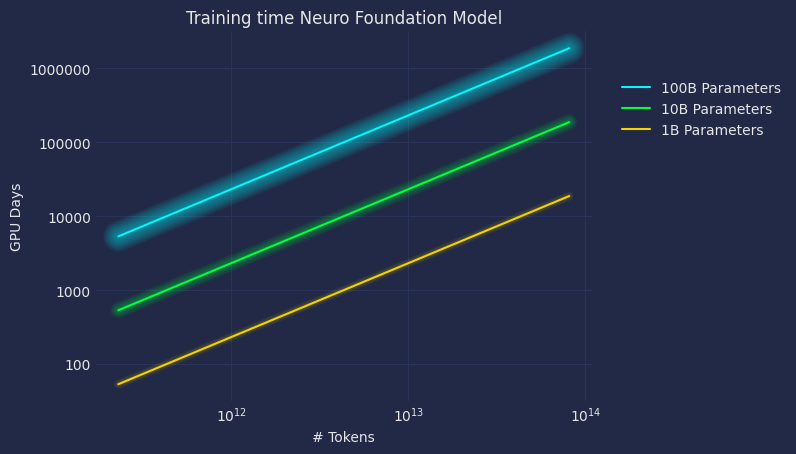

In [23]:
fig, ax = plt.subplots()
x3 = ax.plot(total_tokens, 
             flops_per_model[2] / (flops_per_day ) , 
             label=f"100B Parameters", 
             color="C0", )
x2 = ax.plot(total_tokens, 
             flops_per_model[1] / (flops_per_day ) , 
             label=f"10B Parameters", 
             color="C3", )
x1 = ax.plot(total_tokens, 
             flops_per_model[0] / (flops_per_day ) , 
             label=f"1B Parameters", 
             color="C2", )

plt.yscale('log')
plt.xscale('log')

ax.set(xlabel="# Tokens", ylabel="GPU Days", title="Training time Neuro Foundation Model")
from matplotlib.ticker import ScalarFormatter
for axis in [ ax.yaxis]:
    formatter = ScalarFormatter()
    formatter.set_scientific(False)
    axis.set_major_formatter(formatter)


plt.legend(loc=(1.05, .7))
mplcyberpunk.make_lines_glow(n_glow_lines=5, alpha_line=.2, lines=x1)
mplcyberpunk.make_lines_glow(n_glow_lines=10, alpha_line=.4, lines=x2)
mplcyberpunk.make_lines_glow(n_glow_lines=20, alpha_line=.6, lines=x3)

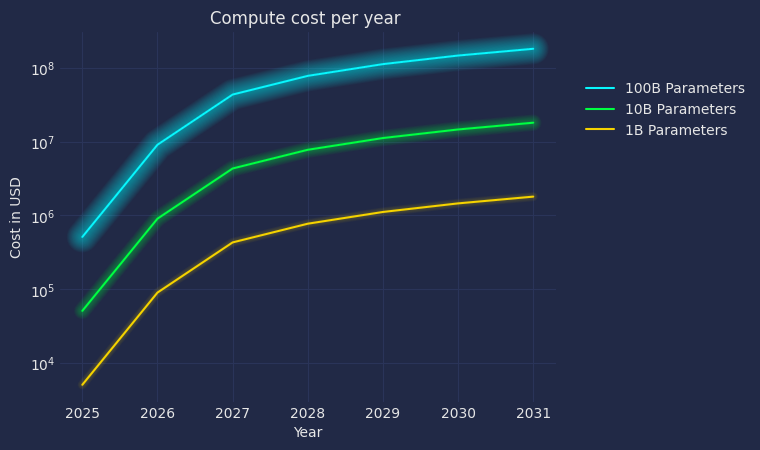

In [24]:
fig, ax = plt.subplots()

x3 = ax.plot(years, 
             flops_per_model[2] / (flops_per_day ) * cost_per_day * inference_cost, 
             label=f"100B Parameters", 
             color="C0", )
x2 = ax.plot(years, 
             flops_per_model[1] / (flops_per_day ) * cost_per_day * inference_cost, 
             label=f"10B Parameters", 
             color="C3", )
x1 = ax.plot(years, 
             flops_per_model[0] / (flops_per_day ) * cost_per_day * inference_cost, 
             label=f"1B Parameters", 
             color="C2", )

plt.yscale('log')

ax.set(xlabel="Year", ylabel="Cost in USD", title="Compute cost per year ")


plt.legend(loc=(1.05, .7))
    
mplcyberpunk.make_lines_glow(n_glow_lines=5, alpha_line=.2, lines=x1)
mplcyberpunk.make_lines_glow(n_glow_lines=10, alpha_line=.4, lines=x2)
mplcyberpunk.make_lines_glow(n_glow_lines=20, alpha_line=.6, lines=x3)

# Subplots

In [ ]:
gpt3_tokens = 400e9
gpt4_tokens = 15e12
llama4_tokens = 40e12
params =[1e9, 10e9, 100e9]
flops_per_day = 300e12 * 3600 * 24 # H200 GPU Flops/day
flops_per_model = [6 * total_tokens * p for p in params] # FLOP estimte from https://www.factorialfunds.com/blog/thoughts-on-llama-3

cost_per_day = 2 * 24
inference_cost = 2

Axes(0.529348,0.11;0.168478x0.77)


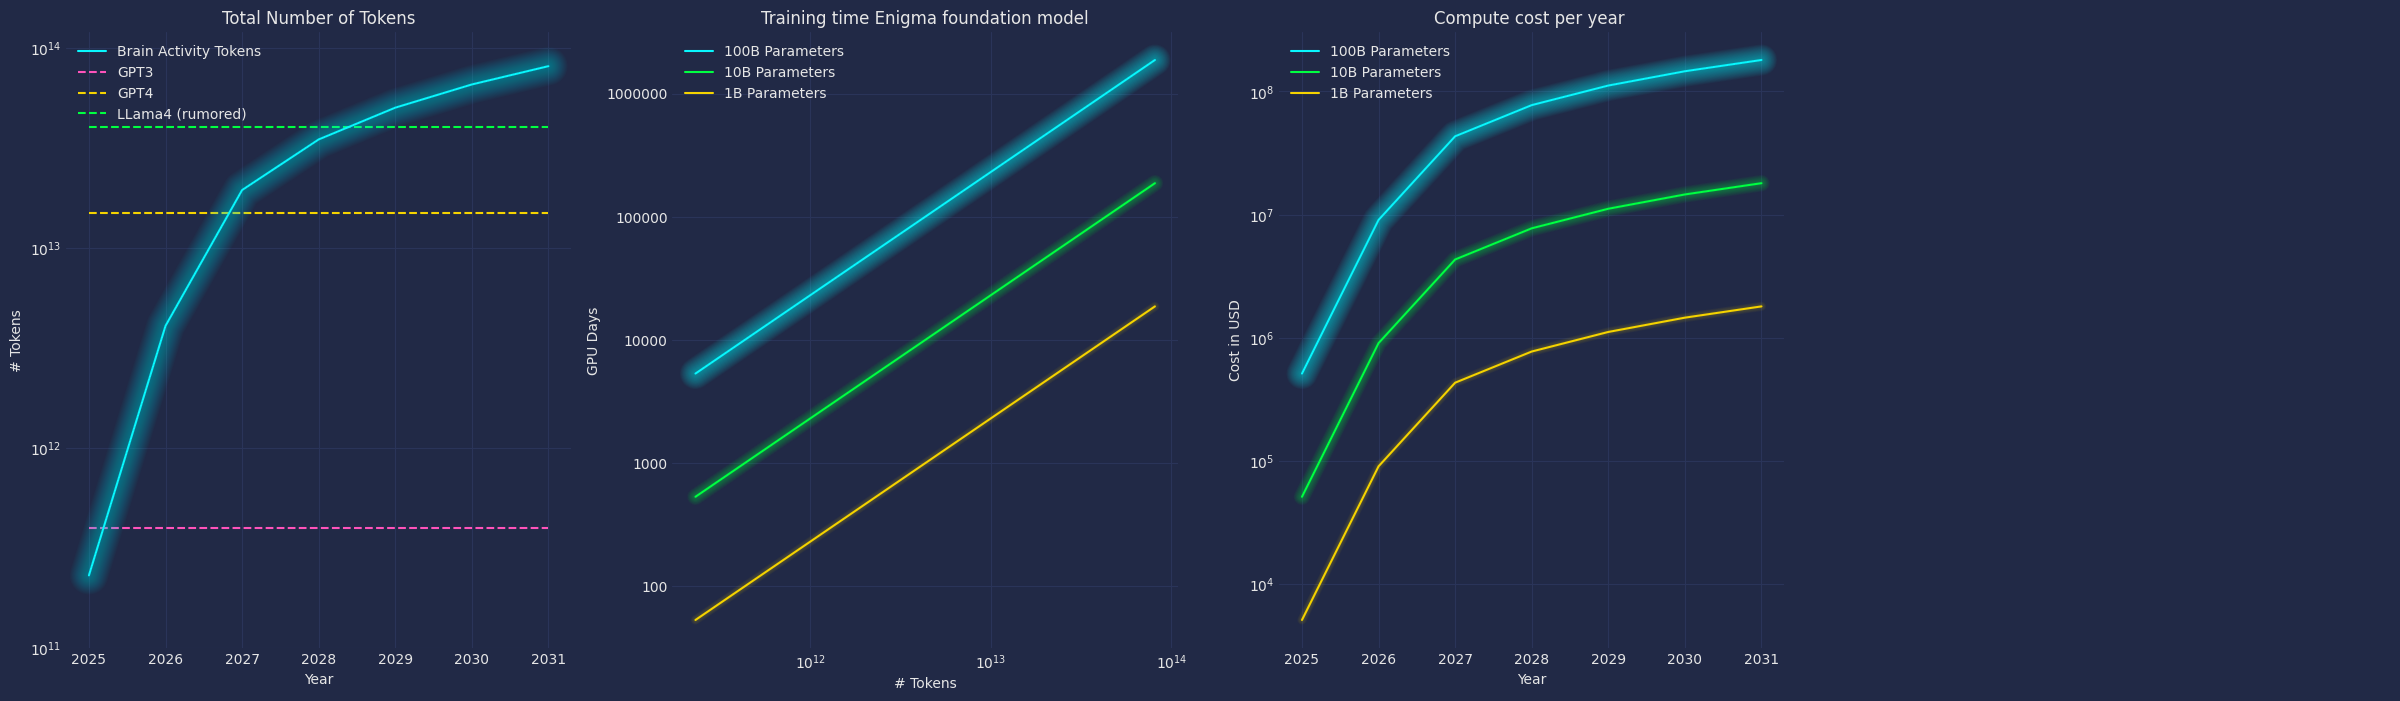

In [73]:
fig, axs = plt.subplots(1, 4, figsize=(30,8))

total_tokens = np.cumsum(n_mua) + np.cumsum(n_spikes) + np.cumsum(n_lfp)
x1 = axs[0].plot(years, total_tokens, label="Brain Activity Tokens", color="C0", zorder=1000)

axs[0].plot([years[0], years[-1]], [gpt3_tokens, gpt3_tokens], '--', label="GPT3", color="C1", )
axs[0].plot([years[0], years[-1]], [gpt4_tokens, gpt4_tokens], '--', label="GPT4", color="C2", )
axs[0].plot([years[0], years[-1]], [llama4_tokens, llama4_tokens], '--', label="LLama4 (rumored)", color="C3", )

axs[0].set(ylabel="# Tokens", xlabel="Year", title="Total Number of Tokens")
axs[0].set_ylim([1e11, 1.2e14])
axs[0].set_yscale('log')

axs[0].legend()


x2 = axs[1].plot(total_tokens, 
             flops_per_model[2] / (flops_per_day ) , 
             label=f"100B Parameters", 
             color="C0", )
x3 = axs[1].plot(total_tokens, 
             flops_per_model[1] / (flops_per_day ) , 
             label=f"10B Parameters", 
             color="C3", )
x4 = axs[1].plot(total_tokens, 
             flops_per_model[0] / (flops_per_day ) , 
             label=f"1B Parameters", 
             color="C2", )

axs[1].set_yscale('log')
axs[1].set_xscale('log')

axs[1].set(xlabel="# Tokens", ylabel="GPU Days", title="Training time Enigma foundation model")
from matplotlib.ticker import ScalarFormatter
for axis in [ axs[1].yaxis]:
    formatter = ScalarFormatter()
    formatter.set_scientific(False)
    axis.set_major_formatter(formatter)
axs[1].legend()


print(axs[2])

x5 =axs[2].plot(years, 
             flops_per_model[2] / (flops_per_day ) * cost_per_day * inference_cost, 
             label=f"100B Parameters", 
             color="C0", )
x6 = axs[2].plot(years, 
             flops_per_model[1] / (flops_per_day ) * cost_per_day * inference_cost, 
             label=f"10B Parameters", 
             color="C3", )
x7 = axs[2].plot(years, 
             flops_per_model[0] / (flops_per_day ) * cost_per_day * inference_cost, 
             label=f"1B Parameters", 
             color="C2", )

axs[2].set_yscale('log')
axs[2].set_xscale("linear")
axs[2].set(xlabel="Year", ylabel="Cost in USD", title="Compute cost per year ")
axs[2].legend()
axs[3].axis("off")

mplcyberpunk.make_lines_glow(n_glow_lines=25, alpha_line=.5, lines=x1)
mplcyberpunk.make_lines_glow(n_glow_lines=5, alpha_line=.2, lines=x4)
mplcyberpunk.make_lines_glow(n_glow_lines=10, alpha_line=.4, lines=x3)
mplcyberpunk.make_lines_glow(n_glow_lines=20, alpha_line=.6, lines=x2)

mplcyberpunk.make_lines_glow(n_glow_lines=5, alpha_line=.2, lines=x7)
mplcyberpunk.make_lines_glow(n_glow_lines=10, alpha_line=.4, lines=x6)
mplcyberpunk.make_lines_glow(n_glow_lines=20, alpha_line=.6, lines=x5)


plt.savefig("Engima_compute_cost.png", dpi=150, bbox_inches="tight")